In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [143]:
data = pd.read_csv('weka2c.csv')
data.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [144]:
o_data = pd.read_csv('weka3c.csv')
o_data.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027818,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


In [145]:
print(o_data.nunique())

pelvic_incidence            310
pelvic_tilt                 310
lumbar_lordosis_angle       280
sacral_slope                281
pelvic_radius               310
degree_spondylolisthesis    310
class                         3
dtype: int64


In [146]:
print(data.nunique())

pelvic_incidence            310
pelvic_tilt numeric         310
lumbar_lordosis_angle       280
sacral_slope                281
pelvic_radius               310
degree_spondylolisthesis    310
class                         2
dtype: int64


In [147]:
data["class"].value_counts()

Abnormal    210
Normal      100
Name: class, dtype: int64

In [148]:
o_data["class"].value_counts()

Spondylolisthesis    150
Normal               100
Hernia                60
Name: class, dtype: int64

I'm going to look at a couple things initially to see what the data looks like, and resolve any potential issues.

1-combine the files and compare classes to ensure there is not a "normal" class that has a hernia or spondylolesthesis

2-separate the classes and compare to degree_spondylolisthesis, see what the separation looks like

3-look at correlation between classification and various measurements

1- I don't know about you but I'm curious to see if the "class" feature of both files match well and I'd like to combine the measurements into 1 file with both classes.  Luckily I can see that degree_spondylolisthesis has 310 unique values and therefore can use these values as "keys" to do a merge on the 2 files.

In [149]:
#merge both files
df2 = pd.merge(o_data, data, on='degree_spondylolisthesis', how='outer')
print(df2)

     pelvic_incidence_x  pelvic_tilt  lumbar_lordosis_angle_x  sacral_slope_x  \
0             63.027818    22.552586                39.609117       40.475232   
1             39.056951    10.060991                25.015378       28.995960   
2             68.832021    22.218482                50.092194       46.613539   
3             69.297008    24.652878                44.311238       44.644130   
4             49.712859     9.652075                28.317406       40.060784   
..                  ...          ...                      ...             ...   
305           47.903565    13.616688                36.000000       34.286877   
306           53.936748    20.721496                29.220534       33.215251   
307           61.446597    22.694968                46.170347       38.751628   
308           45.252792     8.693157                41.583126       36.559635   
309           33.841641     5.073991                36.641233       28.767649   

     pelvic_radius_x  degre

In [150]:
df = df2.copy(deep=True)
df = df[["degree_spondylolisthesis", "class_x", "class_y"]]

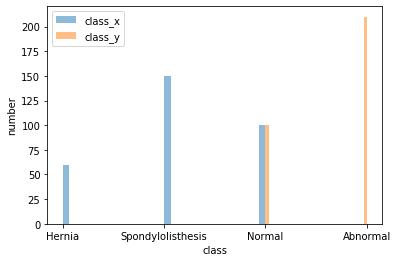

In [151]:
_ = plt.hist(df.class_x, bins=30, alpha = 0.5, label='class_x')
_ = plt.hist(df.class_y, bins=30, alpha=0.5, label='class_y')
_ = plt.xlabel("class")
_ = plt.ylabel("number")
_ = plt.legend()

(array([76., 59., 12.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  1.01004051,  42.76334467,  84.51664883, 126.26995299,
        168.02325715, 209.77656131, 251.52986546, 293.28316962,
        335.03647378, 376.78977794, 418.5430821 ]),
 <a list of 1 Patch objects>)

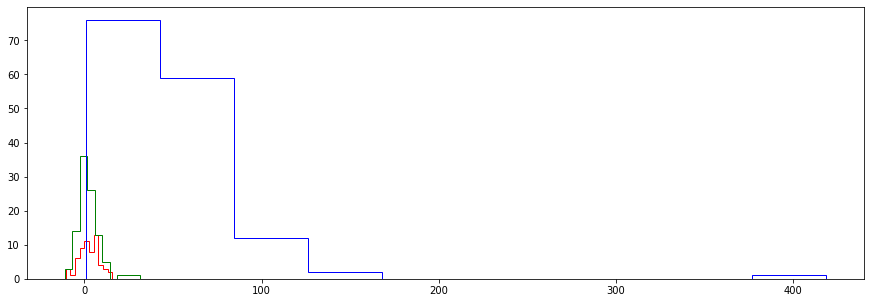

In [152]:

hernia = df[df.class_x == 'Hernia']['degree_spondylolisthesis']
Spondylolisthesis = df[df.class_x == 'Spondylolisthesis']['degree_spondylolisthesis']
normal = df[df.class_x == 'Normal']['degree_spondylolisthesis']

plt.figure(figsize=[15,5])
plt.hist(hernia, histtype='step', color = 'red')
plt.hist(normal, histtype='step', color = 'green')
plt.hist(Spondylolisthesis,  histtype='step', color = 'blue')


In [153]:
print(df)

     degree_spondylolisthesis class_x   class_y
0                   -0.254400  Hernia  Abnormal
1                    4.564259  Hernia  Abnormal
2                   -3.530317  Hernia  Abnormal
3                   11.211523  Hernia  Abnormal
4                    7.918501  Hernia  Abnormal
..                        ...     ...       ...
305                 -4.245395  Normal    Normal
306                 -0.421010  Normal    Normal
307                 -2.707880  Normal    Normal
308                  0.214750  Normal    Normal
309                 -0.199249  Normal    Normal

[310 rows x 3 columns]


from the above figure we see what could be an outlier >360 degrees, upon consultation with physician it is suggested an adjustment should be made by subtracting 360 degrees from the reading.  Without knowing more I've decided to remove the value as a potential outlier and continue without this reading.

(array([ 1.,  1.,  1.,  2.,  1.,  3.,  7., 15.,  9., 15.]),
 array([ 1.01004051,  4.3643311 ,  7.71862169, 11.07291228, 14.42720287,
        17.78149346, 21.13578405, 24.49007464, 27.84436523, 31.19865582,
        34.55294641]),
 <a list of 1 Patch objects>)

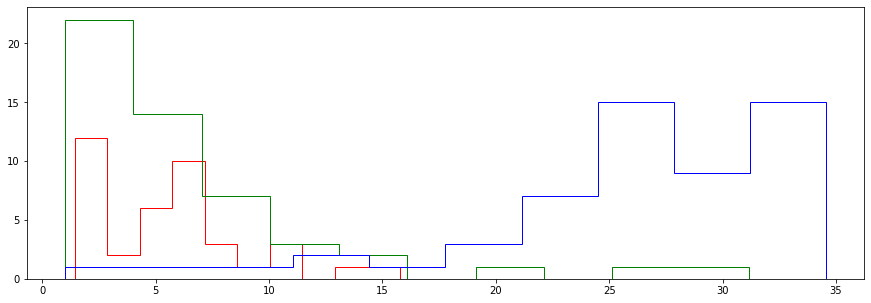

In [165]:
df = df.loc[df['degree_spondylolisthesis'] < 35]
df = df.loc[df['degree_spondylolisthesis'] > 1]
hernia = df[df.class_x == 'Hernia']['degree_spondylolisthesis']
Spondylolisthesis = df[df.class_x == 'Spondylolisthesis']['degree_spondylolisthesis']
normal = df[df.class_x == 'Normal']['degree_spondylolisthesis']

plt.figure(figsize=[15,5])
plt.hist(hernia, histtype='step', color = 'red')
plt.hist(normal, histtype='step', color = 'green')
plt.hist(Spondylolisthesis,  histtype='step', color = 'blue')

There is clearly some overlap, however, Spondylolisthesis has mostly values above the normal or herniated values, these can be separated out with their corresponding probabilities.  I suggest, then taking the remaining, those with degrees less than 40 to see what correlations may separate out the herniated from the normal and spondylolesthesis.

Another option is error in the data.  There is a possibility that some of these labeled as herniated should be spondylolisthesis and vice versa.   We can look at the table of definitions to determine this.

One clear problem is the normal degrees clearly span across most of the herniated.  To determine the differences we need to look at other measurements and see what is the differentiating feature(s).

In [116]:
df3 = df2.copy(deep=True)

     pelvic_incidence_x  pelvic_tilt  lumbar_lordosis_angle_x  sacral_slope_x  \
0             63.027818    22.552586                39.609117       40.475232   
1             39.056951    10.060991                25.015378       28.995960   
2             68.832021    22.218482                50.092194       46.613539   
3             69.297008    24.652878                44.311238       44.644130   
4             49.712859     9.652075                28.317406       40.060784   
..                  ...          ...                      ...             ...   
305           47.903565    13.616688                36.000000       34.286877   
306           53.936748    20.721496                29.220534       33.215251   
307           61.446597    22.694968                46.170347       38.751628   
308           45.252792     8.693157                41.583126       36.559635   
309           33.841641     5.073991                36.641233       28.767649   

     pelvic_radius_x  degre

(array([ 3.,  6.,  7.,  8.,  8., 11., 13.,  9.,  8.,  9.]),
 array([37.90391014, 42.67789779, 47.45188544, 52.22587309, 56.99986074,
        61.77384839, 66.54783604, 71.32182369, 76.09581134, 80.86979899,
        85.64378664]),
 <a list of 1 Patch objects>)

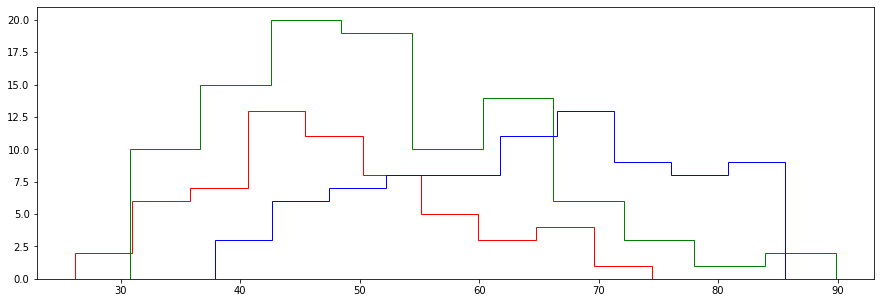

In [119]:
df3 = df2.copy(deep=True)
df3 = df3.loc[df3['degree_spondylolisthesis'] < 20]
df3 = df3[['pelvic_incidence_y', 'class_x']]
hernia = df3[df3.class_x == 'Hernia']['pelvic_incidence_y']
Spondylolisthesis = df3[df3.class_x == 'Spondylolisthesis']['pelvic_incidence_y']
normal = df3[df3.class_x == 'Normal']['pelvic_incidence_y']

plt.figure(figsize=[15,5])
plt.hist(hernia, histtype='step', color = 'red')
plt.hist(normal, histtype='step', color = 'green')
plt.hist(Spondylolisthesis,  histtype='step', color = 'blue')

(array([ 5.,  6.,  5., 15.,  3., 11., 13., 10., 10.,  4.]),
 array([31.84245726, 35.25556088, 38.66866449, 42.08176811, 45.49487172,
        48.90797534, 52.32107896, 55.73418257, 59.14728619, 62.5603898 ,
        65.97349342]),
 <a list of 1 Patch objects>)

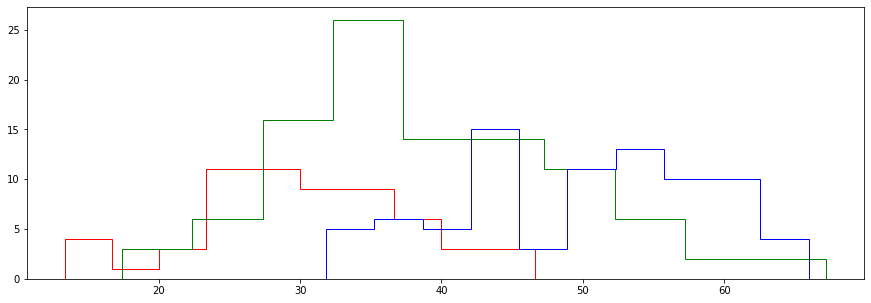

In [121]:
df3 = df2.copy(deep=True)
df3 = df3.loc[df3['degree_spondylolisthesis'] < 50]
df3 = df3[['sacral_slope_y', 'class_x']]
hernia = df3[df3.class_x == 'Hernia']['sacral_slope_y']
Spondylolisthesis = df3[df3.class_x == 'Spondylolisthesis']['sacral_slope_y']
normal = df3[df3.class_x == 'Normal']['sacral_slope_y']

plt.figure(figsize=[15,5])
plt.hist(hernia, histtype='step', color = 'red')
plt.hist(normal, histtype='step', color = 'green')
plt.hist(Spondylolisthesis,  histtype='step', color = 'blue')

(array([ 2.,  2., 10., 17., 26., 18.,  4.,  1.,  0.,  2.]),
 array([ 70.08257486,  79.38142142,  88.68026799,  97.97911455,
        107.27796112, 116.57680768, 125.87565424, 135.17450081,
        144.47334737, 153.77219394, 163.0710405 ]),
 <a list of 1 Patch objects>)

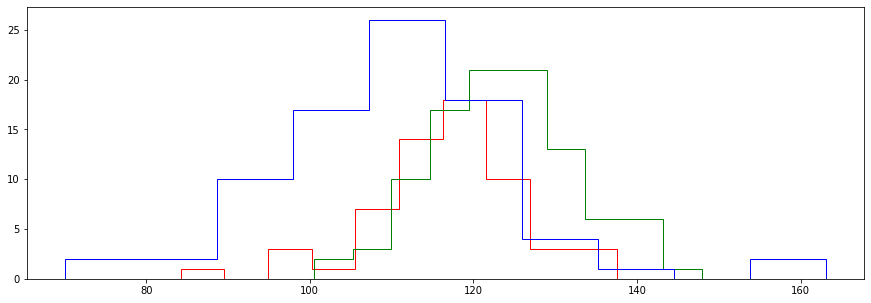

In [122]:
df3 = df2.copy(deep=True)
df3 = df3.loc[df3['degree_spondylolisthesis'] < 50]
df3 = df3[['pelvic_radius_y', 'class_x']]
hernia = df3[df3.class_x == 'Hernia']['pelvic_radius_y']
Spondylolisthesis = df3[df3.class_x == 'Spondylolisthesis']['pelvic_radius_y']
normal = df3[df3.class_x == 'Normal']['pelvic_radius_y']

plt.figure(figsize=[15,5])
plt.hist(hernia, histtype='step', color = 'red')
plt.hist(normal, histtype='step', color = 'green')
plt.hist(Spondylolisthesis,  histtype='step', color = 'blue')

(array([ 1.,  4., 13., 10., 13., 22.,  7.,  3.,  6.,  3.]),
 array([24.71027447, 31.41769654, 38.1251186 , 44.83254067, 51.53996273,
        58.2473848 , 64.95480686, 71.66222892, 78.36965099, 85.07707305,
        91.78449512]),
 <a list of 1 Patch objects>)

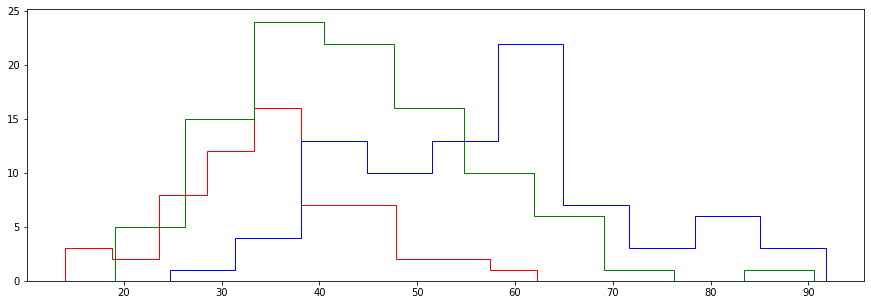

In [123]:
df3 = df2.copy(deep=True)
df3 = df3.loc[df3['degree_spondylolisthesis'] < 50]
df3 = df3[['lumbar_lordosis_angle_y', 'class_x']]
hernia = df3[df3.class_x == 'Hernia']['lumbar_lordosis_angle_y']
Spondylolisthesis = df3[df3.class_x == 'Spondylolisthesis']['lumbar_lordosis_angle_y']
normal = df3[df3.class_x == 'Normal']['lumbar_lordosis_angle_y']

plt.figure(figsize=[15,5])
plt.hist(hernia, histtype='step', color = 'red')
plt.hist(normal, histtype='step', color = 'green')
plt.hist(Spondylolisthesis,  histtype='step', color = 'blue')

(array([ 2.,  3., 10., 14., 27., 16.,  5.,  2.,  1.,  2.]),
 array([-6.55494835, -1.630534  ,  3.29388035,  8.2182947 , 13.14270904,
        18.06712339, 22.99153774, 27.91595209, 32.84036643, 37.76478078,
        42.68919513]),
 <a list of 1 Patch objects>)

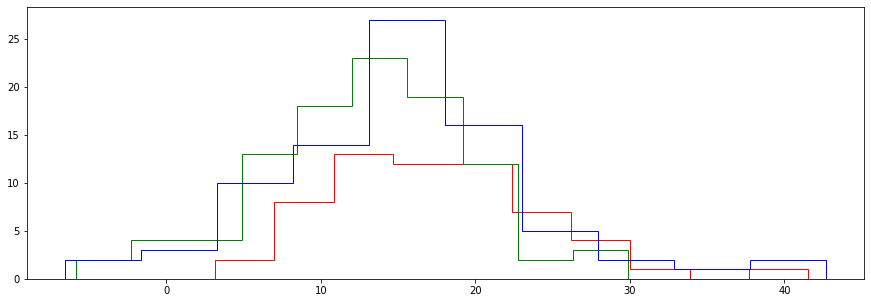

In [124]:
df3 = df2.copy(deep=True)
df3 = df3.loc[df3['degree_spondylolisthesis'] < 50]
df3 = df3[['pelvic_tilt numeric', 'class_x']]
hernia = df3[df3.class_x == 'Hernia']['pelvic_tilt numeric']
Spondylolisthesis = df3[df3.class_x == 'Spondylolisthesis']['pelvic_tilt numeric']
normal = df3[df3.class_x == 'Normal']['pelvic_tilt numeric']

plt.figure(figsize=[15,5])
plt.hist(hernia, histtype='step', color = 'red')
plt.hist(normal, histtype='step', color = 'green')
plt.hist(Spondylolisthesis,  histtype='step', color = 'blue')

From the above exploratinos I would pretty much ignore pelvic tilt as a feature, it is distributed almost identically as the normal.

However, we can see the lumbar lardosis angle is increased for spondylolesthesis while pelvic radius is decreased.  If these two measurements were weighted, value for the pelvic radius less than 140 with lumbar lardosis angle's greater than 40 could be weighted with a higher probability for spondylolesthesis and vice versa.

To separate out the herniated disc I would weight values for increased lumbar lardosis not as muc as for spondylolesthesis and decreased pelvic radius but 

In [141]:
df4 = df2.copy(deep=True)
df4 = df4.loc[df4['degree_spondylolisthesis'] < 50]

hernia = df4[df4.class_x == 'Hernia']

print(hernia)

#plt.figure(figsize=[15,5])
#plt.hist(hernia, histtype='step', color = 'red')



    pelvic_incidence_x  pelvic_tilt  lumbar_lordosis_angle_x  sacral_slope_x  \
0            63.027818    22.552586                39.609117       40.475232   
1            39.056951    10.060991                25.015378       28.995960   
2            68.832021    22.218482                50.092194       46.613539   
3            69.297008    24.652878                44.311238       44.644130   
4            49.712859     9.652075                28.317406       40.060784   
5            40.250200    13.921907                25.124950       26.328293   
6            53.432928    15.864336                37.165934       37.568592   
7            45.366754    10.755611                29.038349       34.611142   
8            43.790190    13.533753                42.690814       30.256437   
9            36.686353     5.010884                41.948751       31.675469   
10           49.706610    13.040974                31.334500       36.665635   
11           31.232387    17.715819     